In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
import seaborn as sns
from datetime import *
from dateutil.relativedelta import relativedelta
from optim import *

In [2]:
cutoff_date = datetime(2023, 4, 30).date()
cutoff_date

datetime.date(2023, 4, 30)

In [3]:
pd.read_excel("portfolioTickers.xlsx")

,highCorrelationPortfolio,mixedCorrelationPortfolio,lowCorrelationPortfolio
0,AEE,PNW,ABT
1,AEP,TKO,AIG
2,CMS,AEP,AKAM
3,D,DUK,AXON
4,DTE,SO,CAG
5,DUK,CNC,CTRA
6,ED,DVA,DECK
7,ES,ED,DLTR
8,EVRG,WEC,MNST
9,LNT,AEE,MOH


Downloading historical prices

In [4]:
tickers = list(pd.read_excel("portfolioTickers.xlsx")["highCorrelationPortfolio"])
prices = yf.download(tickers = tickers, start = "2015-04-30", end = "2025-04-30", progress = False)["Close"].dropna()
prices

YF.download() has changed argument auto_adjust default to True


Ticker,AEE,AEP,CMS,D,DTE,DUK,ED,ES,EVRG,LNT
Date,,,,,,,,,,
2015-04-30,30.227392,39.785179,25.141285,46.859962,48.557419,51.043724,42.686897,34.915638,26.320282,22.148628
2015-05-01,30.419353,39.897110,25.378408,46.873028,48.831837,51.260868,42.763184,35.008720,26.369221,22.346413
2015-05-04,30.707310,40.127975,25.459906,46.912243,49.155025,51.300350,43.068329,35.345280,26.585932,22.661406
2015-05-05,29.968966,39.106586,24.896767,46.297733,47.984234,50.175117,42.180607,34.528965,25.893839,22.137638
2015-05-06,29.806530,38.817009,24.784653,46.225815,47.532986,50.280411,42.374802,34.213875,25.306620,22.046064
...,...,...,...,...,...,...,...,...,...,...
2025-04-23,98.629997,107.019997,73.500000,53.330002,136.160004,121.419998,112.519997,57.959999,68.110001,61.230000
2025-04-24,98.919998,106.699997,74.139999,53.349998,136.979996,120.699997,111.290001,58.529999,68.279999,61.330002
2025-04-25,98.279999,106.739998,72.180000,52.950001,134.759995,119.849998,110.449997,57.860001,67.879997,60.740002


In [5]:
prices_train = prices.loc[:cutoff_date]
prices_test = prices.loc[cutoff_date:]

In [6]:
returns_train = prices_train.pct_change(fill_method = None).dropna()
returns_train

Ticker,AEE,AEP,CMS,D,DTE,DUK,ED,ES,EVRG,LNT
Date,,,,,,,,,,
2015-05-01,0.006351,0.002813,0.009432,0.000279,0.005651,0.004254,0.001787,0.002666,0.001859,0.008930
2015-05-04,0.009466,0.005787,0.003211,0.000837,0.006618,0.000770,0.007136,0.009614,0.008218,0.014096
2015-05-05,-0.024045,-0.025453,-0.022119,-0.013099,-0.023818,-0.021934,-0.020612,-0.023095,-0.026032,-0.023113
2015-05-06,-0.005420,-0.007405,-0.004503,-0.001553,-0.009404,0.002099,0.004604,-0.009125,-0.022678,-0.004137
2015-05-07,0.000743,0.005458,0.000301,0.003112,0.005644,0.005235,0.002291,0.002930,-0.006906,0.001661
...,...,...,...,...,...,...,...,...,...,...
2023-04-24,0.008448,0.003407,0.010222,-0.003292,0.005717,0.005490,0.008077,0.006342,0.001111,0.004522
2023-04-25,0.000441,0.001486,0.005943,-0.003651,0.004110,0.008493,0.005609,0.002899,0.009352,0.003781
2023-04-26,-0.019502,-0.022569,-0.014530,-0.020764,-0.016027,-0.013936,-0.012550,-0.025889,-0.025911,-0.018834


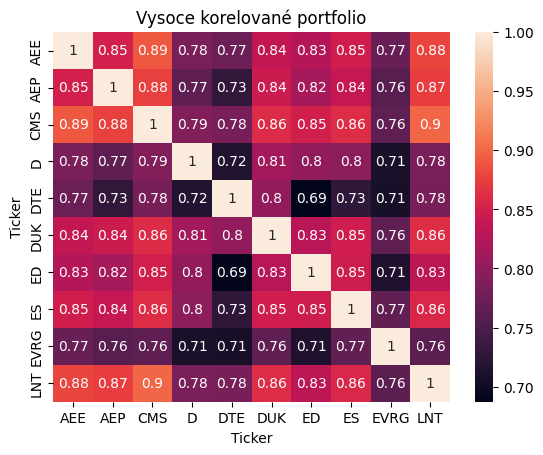

In [7]:
plt.Figure(figsize = (10, 10))
sns.heatmap(returns_train.corr(), annot = True)
plt.title("Vysoce korelované portfolio")
plt.show()

In [8]:
weightsMVOTangent = MVOTangentPortfolio(prices = prices)
weightsPlot(weightsMVOTangent, title = "MVO tangentní portfolio")

Expected annual return: 12.1%
Annual volatility: 20.8%
Sharpe Ratio: 0.58
(np.float64(0.12112735822030754), np.float64(0.2080153808494906), np.float64(0.5823000093822349))


In [9]:
weightsMVOTarget = MVOTargetReturn(prices = prices, target_return = 0.1)
weightsPlot(weightsMVOTarget, title = "MVO optimální portfolio s cílovým výnosem 10% p.a.")

Expected annual return: 10.3%
Annual volatility: 19.4%
Sharpe Ratio: 0.53
(np.float64(0.10260352723698696), np.float64(0.19382120783515064), np.float64(0.5293720350987267))


In [10]:
weightsLWCorrelationTangent = MVOTangentPortfolio(prices = prices, cov_matrix_method = "ledoit_cc")
weightsPlot(weightsLWCorrelationTangent, title = "Robustní MVO tangentní portfolio")

Expected annual return: 12.1%
Annual volatility: 20.6%
Sharpe Ratio: 0.59
(np.float64(0.1210320729594048), np.float64(0.20642906768587627), np.float64(0.5863131307824325))


In [11]:
weightsLWCorrelationTarget = MVOTargetReturn(prices = prices, target_return = 0.1, cov_matrix_method = "ledoit_cc")
weightsPlot(weightsLWCorrelationTarget, title = "Robustní MVO portfolio s cílovým výnosem 10% p.a.")

Expected annual return: 10.3%
Annual volatility: 19.4%
Sharpe Ratio: 0.53
(np.float64(0.10281566413274232), np.float64(0.19355096550344697), np.float64(0.5312071880670173))


In [12]:
weightsCustomDeltaTangent = RobustLedoitWolfCustomDeltaMaxSharpe(prices = prices, custom_delta = 0.5)
weightsPlot(weightsCustomDeltaTangent, title = "Robustní tangentní portfolio s deltou 0.5")

Expected annual return: 11.2%
Annual volatility: 15.3%
Sharpe Ratio: 0.73
(np.float64(0.1116929329674333), np.float64(0.15270291534346211), np.float64(0.7314394274412611))


In [13]:
weightsCustomDeltaTarget = RobustLedoitWolfCustomDeltaTargetReturn(prices = prices, target_return = 0.1, custom_delta = 0.5)
weightsPlot(weightsCustomDeltaTarget, title = "Robustní portfolio s deltou 0.5 a cílovým výnosem 10% p.a.")

Expected annual return: 10.0%
Annual volatility: 14.8%
Sharpe Ratio: 0.68
(np.float64(0.10000000000000002), np.float64(0.14787602070105096), np.float64(0.6762421623595212))


In [14]:
weightsMinCVaR = CVaROptimizationMinCVAR(prices= prices, alpha = 0.05)
weightsPlot(weightsMinCVaR, title = "CVaR optimální portfolio")

Expected annual return: 10.0%
Conditional Value at Risk: 2.84%
(np.float64(0.09983560946027248), np.float64(0.028367113091357962))


In [15]:
anr = pd.DataFrame()

for ticker in tickers:
    rec = pd.read_excel(r"C:\Users\miros\Desktop\masters\BL_Input\AnalystRecommendation.xlsx", sheet_name = ticker)
    rec["Ticker"] = ticker
    anr = pd.concat([anr, rec])

anr["Upside"] = anr["Target Price"] / anr["Last Price"] - 1
anr

,Dates,Target Price,Last Price,Buy %,Hold %,Sell %,Price Spread,Ticker,Upside
0,2023-04-25,94.230766,90.76,0.533333,0.466667,0.000000,3.470766,AEE,0.038241
1,2023-05-25,94.230766,80.95,0.533333,0.466667,0.000000,13.280766,AEE,0.164061
2,2023-06-25,91.857140,80.83,0.600000,0.400000,0.000000,11.027140,AEE,0.136424
3,2023-07-25,91.923080,88.02,0.600000,0.400000,0.000000,3.903080,AEE,0.044343
4,2023-08-25,88.666664,80.45,0.562500,0.437500,0.000000,8.216664,AEE,0.102134
...,...,...,...,...,...,...,...,...,...
20,2024-12-25,62.576923,59.62,0.285714,0.714286,0.000000,2.956923,LNT,0.049596
21,2025-01-25,62.500000,58.77,0.285714,0.714286,0.000000,3.730000,LNT,0.063468
22,2025-02-25,64.038460,63.75,0.285714,0.714286,0.000000,0.288460,LNT,0.004525
23,2025-03-25,64.708336,62.10,0.285714,0.714286,0.000000,2.608336,LNT,0.042002


In [16]:
views = anr.loc[anr["Dates"] == "2023-04-25"][["Ticker", "Upside"]].set_index("Ticker")
views = views["Upside"].to_dict()
views

{'AEE': 0.038241144737623634,
 'CMS': 0.09272712757464463,
 'D': 0.08988902847963653,
 'DTE': 0.11895008750020408,
 'DUK': 0.0903348706637257,
 'ED': -0.09827357744315712,
 'ES': 0.09633392644644667,
 'LNT': 0.03677128676341779}

In [17]:
weightsBLTangent = blackLittermanAbsoluteViewsMaxSharpe(prices = prices, views = views)
weightsPlot(weightsBLTangent, title = "Black-Litterman tangentní portfolio")

Expected annual return: 8.1%
Annual volatility: 20.4%
Sharpe Ratio: 0.40
(np.float64(0.08113110045149748), np.float64(0.20414418520593236), np.float64(0.39742057982036433))


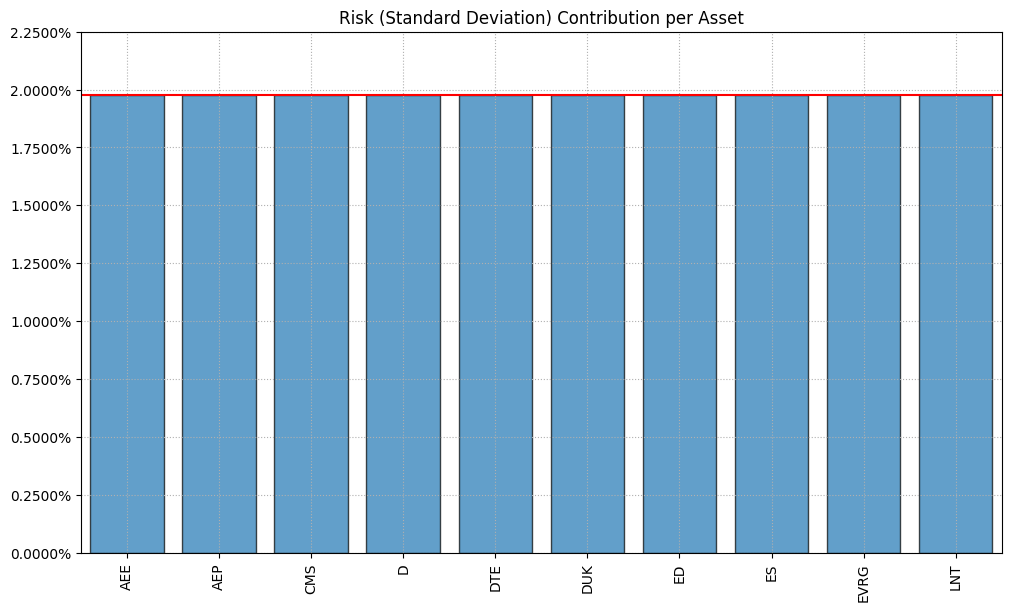

In [18]:
weightsRP_std, rpPlot = riskParityERC(prices = prices)
weightsPlot(weightsRP_std, title = "Rizikově paritní portfolio (směrodatná odchylka)")

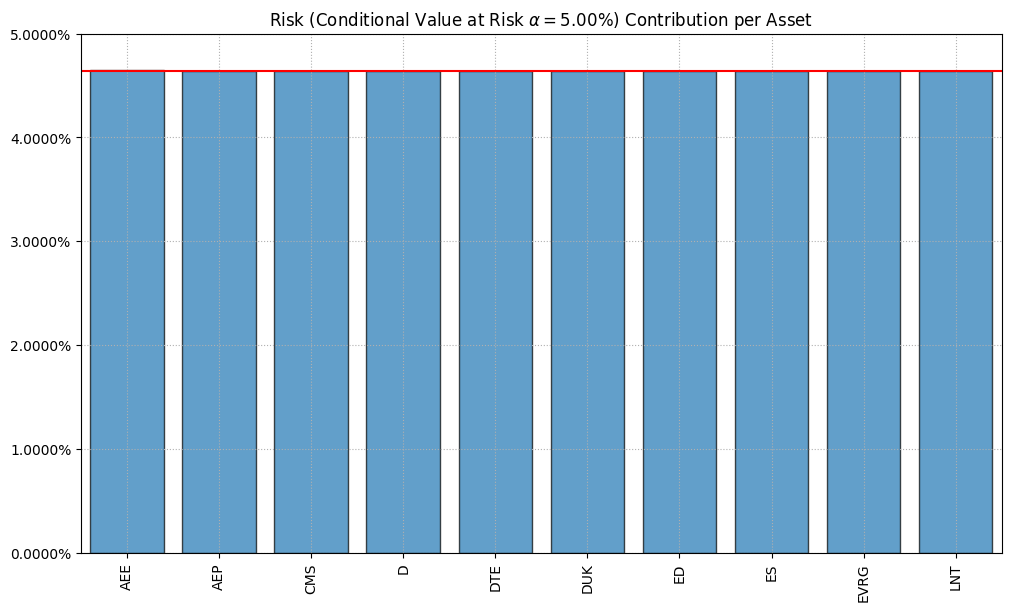

In [19]:
weightsRP_CVaR, rpPlot = riskParityERC(prices = prices, risk_measure = "CVaR")
weightsPlot(weightsRP_CVaR, title = "Rizikově paritní portfolio (CVaR)")

Hierarchical risk parity

In [20]:
in_sample = {
    'MVO Tangent': (weightsRebalancing(weightsMVOTangent, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'MVO Target 10%': (weightsRebalancing(weightsMVOTarget, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'LedoitWolf Tangent': (weightsRebalancing(weightsLWCorrelationTangent, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'LedoitWolf Target 10%': (weightsRebalancing(weightsLWCorrelationTarget, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'MVO Tangent (d = 0.5)': (weightsRebalancing(weightsCustomDeltaTangent, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'MVO Target 10% (d = 0.5)': (weightsRebalancing(weightsCustomDeltaTarget, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'CVaR': (weightsRebalancing(weightsMinCVaR, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'Black-Litterman Tangent': (weightsRebalancing(weightsBLTangent, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'RP (std)': (weightsRebalancing(weightsRP_std, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'RP (CVaR)': (weightsRebalancing(weightsRP_CVaR, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
}

in_sample_returns = pd.DataFrame(in_sample)
in_sample_cumulative_returns = (1 + in_sample_returns).cumprod()
in_sample_cumulative_returns_max = in_sample_cumulative_returns.cummax()
in_sample_drawdowns = (in_sample_cumulative_returns - in_sample_cumulative_returns_max)/in_sample_cumulative_returns_max

px.line(in_sample_cumulative_returns)

In [21]:
px.line(in_sample_drawdowns, title = 'Drawdowns')

In [22]:
in_sample_returns.std().sort_values().map('{:.3%}'.format)

MVO Target 10%              1.259%
LedoitWolf Target 10%       1.265%
MVO Target 10% (d = 0.5)    1.271%
CVaR                        1.273%
RP (std)                    1.279%
RP (CVaR)                   1.279%
MVO Tangent (d = 0.5)       1.286%
Black-Litterman Tangent     1.322%
MVO Tangent                 1.349%
LedoitWolf Tangent          1.350%
dtype: object

In [23]:
in_sample_drawdowns.min().sort_values().map('{:.3%}'.format)

Black-Litterman Tangent     -38.243%
MVO Target 10%              -33.679%
CVaR                        -33.239%
MVO Target 10% (d = 0.5)    -33.163%
RP (std)                    -33.096%
RP (CVaR)                   -33.085%
LedoitWolf Target 10%       -32.911%
MVO Tangent (d = 0.5)       -32.125%
MVO Tangent                 -29.927%
LedoitWolf Tangent          -29.341%
dtype: object

In [24]:
in_sample_cagr = (1 + in_sample_returns).prod() ** (252 / len(in_sample_returns)) - 1
in_sample_cagr.sort_values().map('{:.2%}'.format)

Black-Litterman Tangent      9.22%
CVaR                        10.52%
LedoitWolf Target 10%       10.57%
RP (std)                    10.71%
RP (CVaR)                   10.71%
MVO Target 10%              10.84%
MVO Target 10% (d = 0.5)    11.07%
MVO Tangent (d = 0.5)       12.25%
LedoitWolf Tangent          12.96%
MVO Tangent                 13.05%
dtype: object

In [25]:
returns_test = prices_test.pct_change(fill_method=None).dropna()
returns_test

Ticker,AEE,AEP,CMS,D,DTE,DUK,ED,ES,EVRG,LNT
Date,,,,,,,,,,
2023-05-02,-0.005802,-0.014787,-0.002433,-0.027836,-0.012040,-0.015037,-0.005449,-0.016469,-0.016488,-0.013565
2023-05-03,-0.005162,-0.004492,-0.004879,0.004142,0.000269,-0.002766,-0.005377,0.002617,0.003906,-0.002017
2023-05-04,0.012408,0.006273,0.009687,0.014527,0.009406,0.008014,0.004896,0.001044,0.008106,0.006798
2023-05-05,0.008022,0.007327,0.011258,-0.001414,0.006035,0.012741,0.009846,0.009385,0.006594,0.005657
2023-05-08,-0.014701,0.000326,-0.012746,0.000177,-0.003176,-0.004630,-0.004825,-0.008910,-0.008627,-0.006351
...,...,...,...,...,...,...,...,...,...,...
2025-04-23,-0.005245,-0.010448,-0.002714,-0.001311,0.002651,-0.009059,-0.006884,-0.001550,-0.003657,0.003277
2025-04-24,0.002940,-0.002990,0.008707,0.000375,0.006022,-0.005930,-0.010931,0.009834,0.002496,0.001633
2025-04-25,-0.006470,0.000375,-0.026436,-0.007498,-0.016207,-0.007042,-0.007548,-0.011447,-0.005858,-0.009620


In [26]:
out_of_sample = {
    'MVO Tangent': (weightsRebalancing(weightsMVOTangent, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'MVO Target 10%': (weightsRebalancing(weightsMVOTarget, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'LedoitWolf Tangent': (weightsRebalancing(weightsLWCorrelationTangent, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'LedoitWolf Target 10%': (weightsRebalancing(weightsLWCorrelationTarget, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'MVO Tangent (d = 0.5)': (weightsRebalancing(weightsCustomDeltaTangent, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'MVO Target 10% (d = 0.5)': (weightsRebalancing(weightsCustomDeltaTarget, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'CVaR': (weightsRebalancing(weightsMinCVaR, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'Black-Litterman Tangent': (weightsRebalancing(weightsBLTangent, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'RP (std)': (weightsRebalancing(weightsRP_std, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'RP (CVaR)': (weightsRebalancing(weightsRP_CVaR, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
}

out_of_sample_returns = pd.DataFrame(out_of_sample)
out_of_sample_cumulative_returns = (1 + out_of_sample_returns).cumprod()
out_of_sample_cumulative_returns_max = out_of_sample_cumulative_returns.cummax()
out_of_sample_drawdowns = (out_of_sample_cumulative_returns - out_of_sample_cumulative_returns_max)/out_of_sample_cumulative_returns_max

px.line(out_of_sample_cumulative_returns)

In [33]:
pd.DataFrame(out_of_sample_returns.std().sort_values(ascending=False).map('{:.3%}'.format)).rename(columns = {0: "std"})

,std
MVO Tangent,1.144%
LedoitWolf Tangent,1.139%
Black-Litterman Tangent,1.119%
RP (std),1.097%
RP (CVaR),1.097%
MVO Tangent (d = 0.5),1.078%
MVO Target 10% (d = 0.5),1.071%
LedoitWolf Target 10%,1.055%
MVO Target 10%,1.055%
CVaR,1.046%


In [34]:
pd.DataFrame(out_of_sample_drawdowns.min().sort_values().map('{:.3%}'.format)).rename(columns = {0: "MDD"})

,MDD
LedoitWolf Tangent,-19.079%
MVO Tangent,-18.918%
RP (CVaR),-18.567%
RP (std),-18.532%
MVO Tangent (d = 0.5),-17.807%
MVO Target 10% (d = 0.5),-17.672%
MVO Target 10%,-16.642%
CVaR,-16.582%
Black-Litterman Tangent,-16.521%
LedoitWolf Target 10%,-16.162%


In [35]:
out_of_sample_cagr = (1 + out_of_sample_returns).prod() ** (252 / len(out_of_sample_returns)) - 1
pd.DataFrame(out_of_sample_cagr.sort_values(ascending=False).map('{:.2%}'.format)).rename(columns = {0: "CAGR"})

,CAGR
LedoitWolf Target 10%,13.83%
Black-Litterman Tangent,13.70%
MVO Target 10%,13.64%
CVaR,13.04%
MVO Tangent (d = 0.5),12.23%
MVO Target 10% (d = 0.5),11.90%
LedoitWolf Tangent,11.11%
MVO Tangent,11.08%
RP (std),10.20%
RP (CVaR),10.19%


In [36]:
pd.DataFrame((out_of_sample_cagr / (out_of_sample_returns.std() * np.sqrt(252))).sort_values(ascending= False)).rename(columns = {0: "CAGR/std"})

,CAGR/std
LedoitWolf Target 10%,0.825536
MVO Target 10%,0.814255
CVaR,0.784972
Black-Litterman Tangent,0.771393
MVO Tangent (d = 0.5),0.715101
MVO Target 10% (d = 0.5),0.700049
LedoitWolf Tangent,0.614718
MVO Tangent,0.610407
RP (std),0.585611
RP (CVaR),0.584935
